# Exploring Huggingface Transformers

## Some opening questions:

1. What is Hugging Face?
2. What is a transformer?
3. What is Hugging Face [`transformers`](https://huggingface.co/transformers/)?

The answers to these questions will serve as important background for this notebook.  

## Let's get started

Unlike the `openai` library, we don't need to install `transformers` because it's already included as part of Colab's default Python environemnt. But we do need to import the specific packages we want to use.

We're going to start very quickly with prompting to see how we can do the same thing we did last class without relying on OpenAI and its pay-for-access models. To do this, we need the transformer's `pipeline` functions, which--like the API for chatGPT--give us some objects we can use for a bunch of basic NLP (and related) tasks. We also need something called `torch` which gives use a data structure called a Tensor which is, essentially, a multidimensional array.

In [ ]:
# import libraries
from transformers import pipeline
import torch

### Picking the model

Now we pick the model. This is something we didn't do in our previous class, since CAIL set us up with GPT-4-32k. But as it turns out, there are SO MANY options. Like, tens and tens of thousands. [Here is a good overview](https://huggingface.co/docs/hub/en/transformers) of the various flavors, as well as instructions for how you can tell which ones you can access via `transformers`.

At a high level, there are two kinds of transformer models: **decoder-only** and **encoder-decoder**. Most current LLMs are decoder-only transformers. Some examples include: GPT-4 (which we used last class) and its siblings, along with LLaMA and Llama2 (both from Meta), OLMo (AI2), Mixtral (Mistral AI), and Claude (Anthropic). However, you may encounter encoder-decoder transformer LLMs as well, for instance, Flan-T5 and Gemini (both Google) and BART (Meta).

How do you know whether you want a decoder-only model or an encoder-decoder one? There are lots of considerations that you should put into your choice of model, ranging from model size (and corresponding questions of time, compute, and environmental impact), to level of openness and documentation, to the politics of the company, and so on. But there are some technical considerations as well. From the [Hugging Face documentation](https://huggingface.co/docs/transformers/tasks/prompting#best-practices-of-llm-prompting):

> "Encoder-decoder-style models are typically used in generative tasks where the output heavily relies on the input, for example, in translation and summarization. The decoder-only models are used for all other types of generative tasks."

Put more simply, decoder-only models use one set of parameters for processing everything, while encoder-decoder models use different sets for processing input and for generating output. More on this distinction [here](https://discuss.huggingface.co/t/decoder-vs-encoder-decoder-clarification/44330/4).

In short, deciding which arcitecture you want, as well as the specific model to use, depends on the task that you want to use it for.

With `transformers`, it's also important to know what type of LLM you are using because they use different pipelines:

You run inference with decoder-only models with the `text-generation` pipeline, but you run inference with an encoder-decoder with the `text2text-generation` pipeline.

### Base vs. instruct/chat models

There are so many distinctions!

A lot of current LLMs release **checkpoints**. These are essentially saved states of the model's parameters at certain points in the training process. Early checkpoints are used if you need (or want) to stop training and resume training at a later date, or to examine or audit changes that take place during the training process. But the last checkpoints represent the fully trained model. Increasingly, with the turn to instruction-tuned models, companies will release a checkpoint of the base model before instruction-tuning, which you can use if you just want to generate text in a sequence, and then an instruction-tuned one, if you plan to ask the model to perform specific tasks.

Again from the [Hugging Face docs](https://huggingface.co/docs/transformers/tasks/prompting#best-practices-of-llm-prompting):
> "Base models are excellent at completing the text when given an initial prompt, however, they are not ideal for NLP tasks where they need to follow instructions, or for conversational use. This is where the instruct (chat) versions come in. These checkpoints are the result of further fine-tuning of the pre-trained base versions on instructions and conversational data. This additional fine-tuning makes them a better choice for many NLP tasks."


### Our first model

Let's just start with [GPT-2](https://huggingface.co/openai-community/gpt2), the model that Hugging Face suggests on its tutorial page. It's an older GPT, which is why it's now open and free to use. While its output is not quite as nuanced as more recent GPTs, it's also smaller and therefore faster to query, and requires fewer resources (both compute and energy) to use.

This is how you set the model and query it using the `text-generation` pipeline:

In [ ]:
# for nicely formatted printing
import textwrap

# torch.manual_seed(0)   # uncomment for reproducibility
generator = pipeline('text-generation',
                     model = 'openai-community/gpt2',
                     # device = 'cuda'. # set cuda for GPUs; we don't need this yet so let's not
                     )

prompt = "People have a lot of opionions about cilantro. Some people think cilantro tastes like"

responses = generator(prompt,
                      max_length = 50,
                      num_return_sequences=10,
                      temperature=1.0,
                      truncation=True
                      )

#  print out the responses
for i, response in enumerate(responses):
    print()
    print(str(i) + ". " + textwrap.fill(response['generated_text'],100))


## A quick aside about temperature

Last class, we talked about temperature, the easiest hyperparameter to set when you want to impact the randomness of the model's output. Now that we're able to manipulate individaul tensors with `torch`, we can begin to understand it a bit more.

First off, why is it called temperature? Eric asked this last class and I wasn't sure, so I googled around. Tl;dr: physics!

But the longer answer is as follows: We've already talked a little about how these models work by generating probability distributions for the most likely words to come next (well, technically, the next tokens--but we'll get to that distinction later in the class).  

Anyway, the numbers that result from the model are not probabilities but in fact logits--raw values that can be placed on a linear scale, but very crucially, are difficult to compare with one another because of the unspecified range.

To get probabilities, we use a Softmax transformation, which you may or may not have heard about in some of your other classes. If not, or even if so, here is a picture:

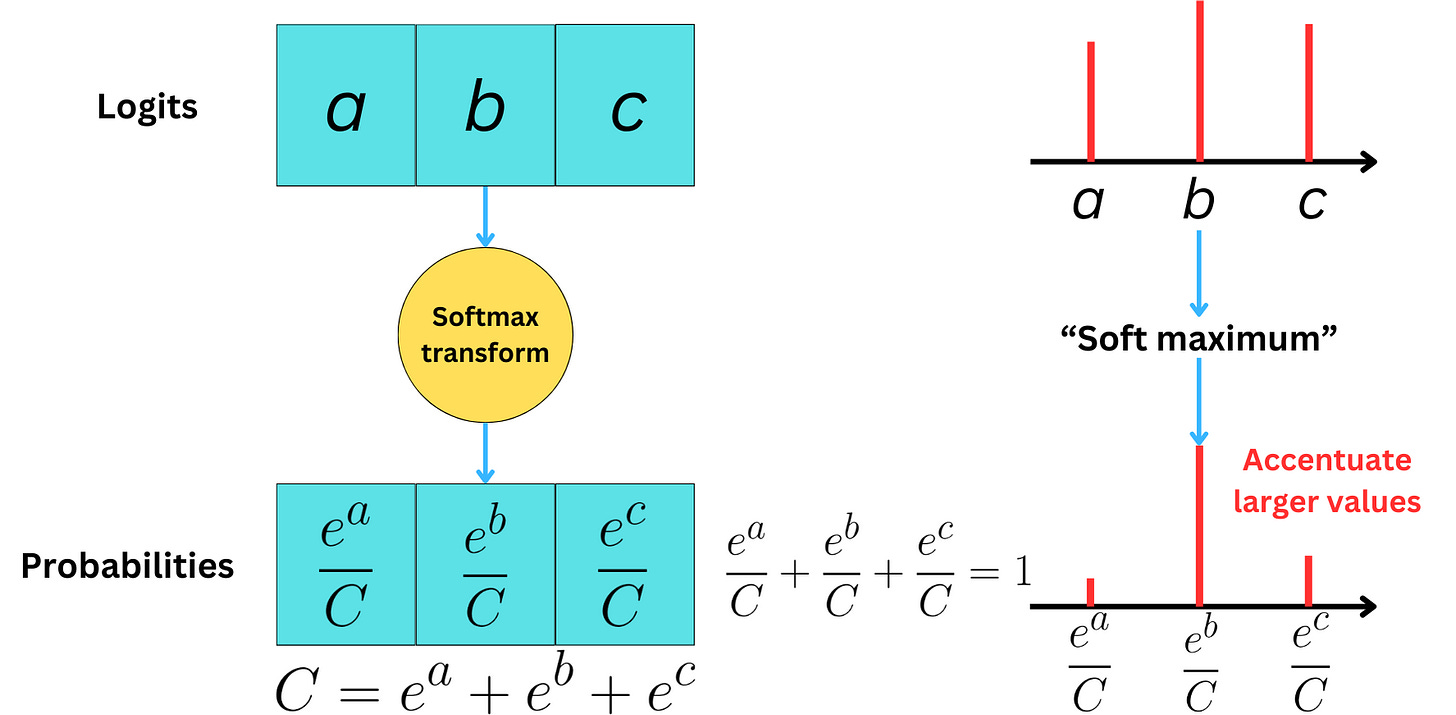

*Image above from [Damien Benveniste's actually quite helpful LinkedIn post on temperature](https://www.linkedin.com/pulse/what-temperature-large-language-model-damien-benveniste-0kd2c/).*

The problem with the Softmax transformation is it's very dependent on the specific analytical form of that function--as we would be for any function we might pick. In any case, this is something that folks in Physics have known for a long time, where they use the same thing as the Softmax function a lot, except by the name Boltzmann or Gibbs distribution. These distributions represent the energy levels of groups of particles.

Similar to how actual temperature (like of the air) influences the movement of particles in a system, with higher temperatures leading to more unpredictable behavior and lower temperatures resulting in more predictable, deterministic outputs, so too does the teperature parameter.

Essentially, it controls the "heat" of the model's decision-making process when choosing the next word to generate.

Here's another (possibly?) helpful diagram from Benveniste:

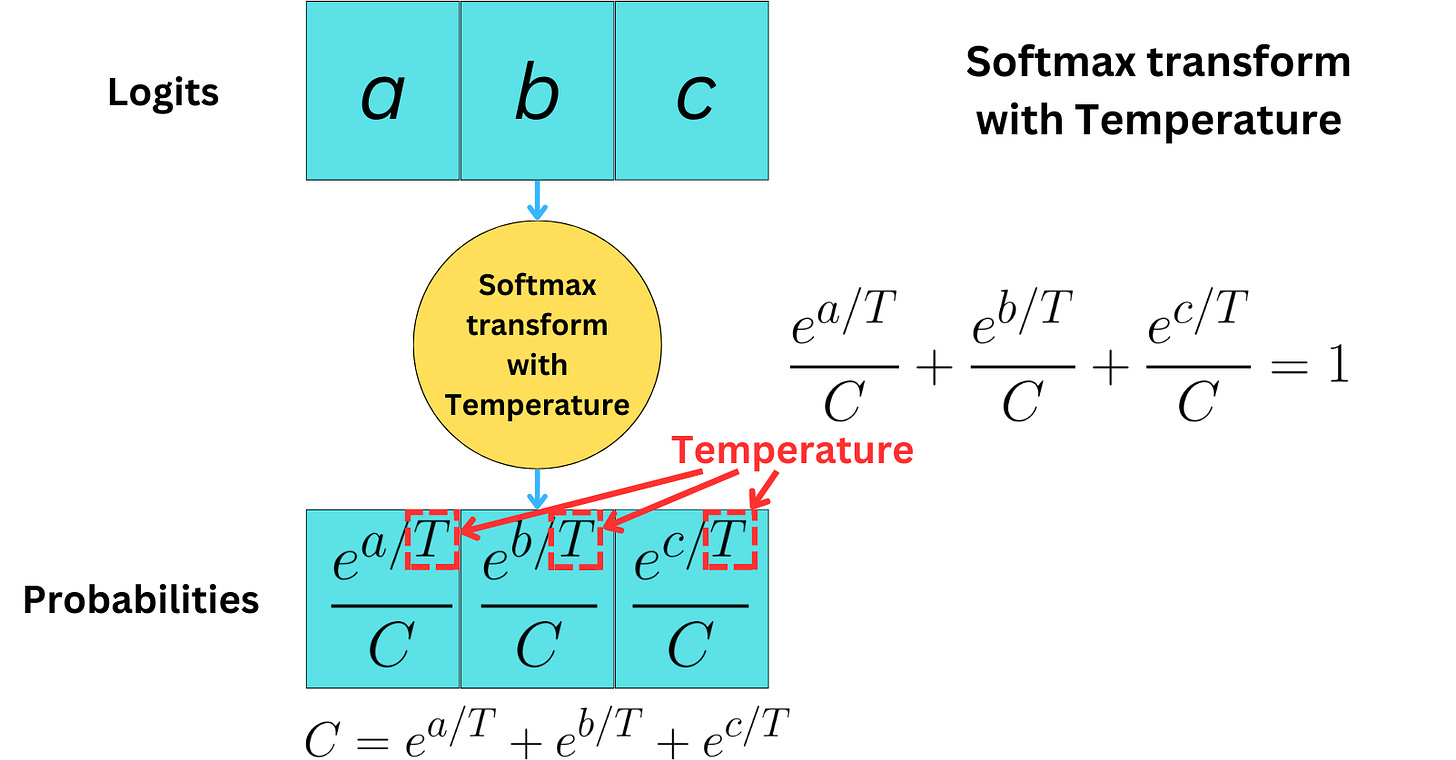

And the same thing but with demonstrated words:

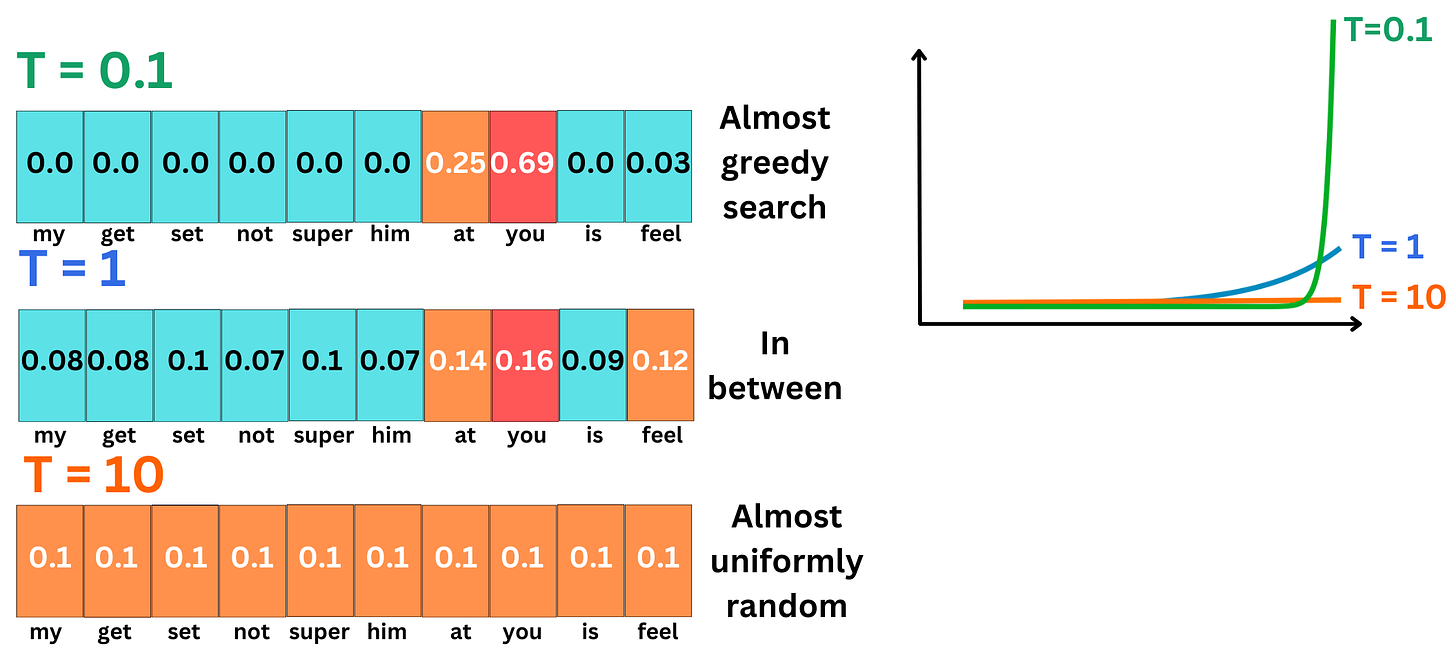

## Now let's try it out

To get a more intuitive understanding of this, let's imagine that the model only has five tokens in its vocabulary (instead of 50,000+). A schematic illustration of those probabilities might look like this:

    prompt: Whose woods these are I think I
    probabilities:
        know -> 0.5
        knew -> 0.2
        smell -> 0.15
        see -> 0.1
        am -> 0.05

The probabilities will add up to 1.0. A probability of 0.5 indicates that the token has a 50% probability of coming next; a probability of 0.2 means that the token has a 20% probability of coming next, etc.

Here are those probabilities represented in Python as two lists—one with the words, and one with the probabilities that correspond to those words by index:

In [ ]:
tokens = ['know', 'knew', 'smell', 'see', 'am']
probs = [0.5, 0.2, 0.15, 0.1, 0.05]

By default, to select the next token, the generation code picks from this list weighted by probability. The code to do this with PyTorch looks like this:

In [ ]:
index = torch.multinomial(torch.tensor(probs), 1).item()
print(tokens[index])

You don't have to worry about the specifics of this code—I'm just using it to demonstrate how the sampling process works. Run the code a few times and you'll see that about half the time you get "knew"—the token with the highest probability. Running the code in a loop makes this a bit easier to see:

In [ ]:
for i in range(10):
    index = torch.multinomial(torch.tensor(probs), 1).item()
    print(tokens[index])

Enter temperature. This lets you shift the probability distribution of the next token before it's sampled.

As discussed last class, if the temperature parameter is 1.0, then sampling will proceed as normal, with the tokens weighted by their estimated probability. If the temperature parameter is less than 1.0, then tokens that were already probable will get more probable. If the temperature parameter is greater than 1.0, then the probabilities start to even out, approaching a uniform distribution (meaning that no token is more likely to be chosen than any other).

To demonstrate this, I've written some code below that applies temperature to the probabilities defined above, and shows the resulting changes:

In [ ]:
for temperature in [0.1, 0.35, 1.0, 2.0, 50.0]:
    modified = torch.softmax(
        torch.log(torch.tensor(probs)) / temperature, dim=-1)

    print(f"temperature {temperature:0.02f}")

    for tok, prob in zip(tokens, modified):
        print(tok.ljust(6), "→", f"{prob:0.002f}")

    print()

You can see that at temperature 1.0, the probabilities are identical to the original. At temperature 0.35, the probability of the most likely token has been boosted, but the other tokens still have a small chance of occurring. At temperature 0.1, only the most likely token has a chance of being selected. At temperature 2.0, the most likely token is still the most likely, but the probabilities of the other tokens have been boosted in comparison; at temperature 50.0, no token is considered to be more likely than any other.

Now let's go back to our original example and play around with the temperature. Try a small value (< 1) and a very large value ( > 10) and see what results.

In [ ]:
# torch.manual_seed(0)   # uncomment for reproducibility
generator = pipeline('text-generation',
                     model = 'openai-community/gpt2',
                     # device = 'cuda'. # set cuda for GPUs; we don't need this yet so let's not
                     )

prompt = "People have a lot of opionions about cilantro. Some people think cilantro tastes like"

responses = generator(prompt,
                      max_length = 100,
                      temperature=20.0, # <-- HERE IS TEMPERATURE
                      truncation=True
                      )

print("\n" + textwrap.fill(responses[0]['generated_text'],100))

As you experienced, low temperatures generally produce predictable, repetitive results, while higher temperature example produces less likely sequences of words. The text is a bit livelier, but sometimes at the cost of coherence.

Adjusting the temperature can be useful when you want the text to be more or less "weird." It can be helpful to adjust the temperature downward when you feel as though the model is producing text that is a bit too unpredictable; it can be helpful to adjust upward when you want to model to take more unexpected turns when generating.

## Top-k filtering and logit warping

While temperature is the most commonn (and usually the only) parameter that people touch when attempting to modify the output of the model when generating text, there are a few other ways you can play with the output, including top-k filtering and logit warping. We may or may not have time to cover them later in the semester, so if not, [here is a notebook from another course I taught](https://github.com/emory-qtm/2023-quant-lit/blob/main/labs/transformers_playground_lk.ipynb) that, midway down the page, will show you what these are and how to use them.

## Other Transformers Pipelines

For now, though, we're going to learn about a few common uses of LLMs for NLP and related research, and how to implement them with `transformers`.

A big one is called [masked langauge modeling](https://huggingface.co/docs/transformers/en/tasks/masked_language_modeling), which predicts a masked token in a sequence of words. This is useful when you want to audit a model for some form of bias; or when you're trying to determine the similarity of one word to others; or if you want to identify typos and other word-level errors in your data that you want to fix; or many other use cases. It's a good thing to know about!

For our MLM exercise, we're going to use the [DistilRoBERTa](https://huggingface.co/distilbert/distilroberta-base) base model. The [RoBERTa](https://huggingface.co/FacebookAI/roberta-base) family of models are trained on English language texts for the specific task of masked langauge modeling, so they're the standard models to use. The "distiled" version is a smaller, faster, *distilled* version of the larger model. (This terminology is used more broadly in LLM-land). The goal with distilled models is to reduce the number of parameters while preserving performance. It's often true that you can prune a significant number of parameters while still attaining a high degree of performance.  

In any case, this is how you do it:

In [ ]:
# torch.manual_seed(0)   # uncomment for reproducibility
unmasker = pipeline('fill-mask',  # note different pipeline
                     model = 'distilroberta-base',  # note different model
                     # device = 'cuda'. # set cuda for GPUs; we don't need this yet so let's not
                     )

template = "Last weekend, I went to the <mask>"

responses = unmasker(template,
                    top_k = 5, # default is also 5
                      )

responses

What you are looking at here is:

1.  The confidence score
2.  The token ID
3.  The token that's been suggested; and
4.  The completed sequence.

The confidence score becomes a helpful metric if you want to do something like provide quantative evidence of bias, or sum over possible choices, or something like that.

As with the output of the `generator` pipeline, you can acess it by iterating through the dictionary items like so:

In [ ]:
# confidence score of first / highest prob token
responses[0]["score"]

Let's put these numbers to use in a mini experiment: scanning for gender bias in occupations in the model. You'll recognize some familiar syntax here:

In [ ]:
pronouns = ["He", "She", "They"]

# define our template function
def construct_template (pronoun):
  template = "After college, " + pronoun + " worked as a <mask>."
  return template

# define our unmasker function
def unmask_gender(template):
  responses = unmasker(template, top_k = 5)

  return responses

# put both to use
for pronoun in pronouns:
  responses = unmask_gender(construct_template(pronoun))

  print("Pronoun: " + pronoun)

  for i, response in enumerate(responses):
    print(responses[i]["token_str"] + str(responses[i]["score"]))

  print("\n")

**Question:** What can we observe on the basis of the differences betweeen these top completions?

## Learning more

There are a lot more of these pipelines, which you can learn about via the `transformers` documentation. We'll come back to some of these as we learn more about the underlying task they've been designed to perform. If you're curious, you can get a head start [here](https://huggingface.co/docs/transformers/en/main_classes/pipelines).

You can also take a look at a few other examples from [this notebook from the 2022 iteration of this course](https://github.com/laurenfklein/QTM340-Fall22/blob/main/notebooks/class21_huggingface_pipeline_functions.ipynb).